# Heterogenous mechanics grid convergence
For this study, we use the methods supplied in `abstract-grid-convergence`

First, we paste the methods needed for grid convergence, then the methods needed to solve heterogenous pure mechanics

In [23]:
import numpy as np
import scipy.sparse as sps
import porepy as pp
import matplotlib.pyplot as plt

from porepy.geometry.geometry_property_checks import is_ccw_polyline
from porepy.geometry.geometry_property_checks import is_ccw_polygon
from porepy.geometry.geometry_property_checks import point_in_polygon

## Grid convergence methods 

In [24]:
def make_points_ccw(p, tol=1e-5):
    """
    Return the points sorted in ccw order.
    
    Sort points in 2D, by ccw order. Not tested for non-convex point sets.
    
    Parameters:
        p (np.ndarray, 2 x n): Points to be sorted.
    
    Returns:
        np.ndarray, ccw sorted list of points.
        
    Steps of algorithm:
    Let poly = p.copy()
    
    CASE I: 3 points provided.
    1. Check if points are collinear.
        - If True: Raise ValueError.
    2. Run is_ccw_polyline(poly) 
        - If True: Return poly
        - Otherwise: Return poly.copy()[:, ::-1]
        
    CASE II: 4 points provided.
    1. Name the points A,B,C,D.
    2. Consider two points, e.g. AB.
    3. Check if any of C and D is collinear to AB.
        a. If any:
            - Raise ValueError
    3. Check that C and D is ccw relative to AB
        a. If both cw: 
            - Continue with XY = BA.
        b. If one cw and one ccw:
            - Continue with XY = AC (or AD, it doesn't matter)
        c. If both ccw: 
            - Continue with XY = AB
    4. Name the other two points Z, W.
    5. Run is_ccw_polygon on XYZW and XYWZ.
        a. Return the case which is True.
        
    CASE III: Number of points provided > 4.
    1. Raise NotYetImplementedError.
    
    """
    
    num_p = p.shape[1]
    poly = p.copy()
    
    assert(num_p > 2) # Need to provide at least 3 points.
    
    # CASE I:
    if num_p == 3:
        A,B,C = poly.T
        if np.abs(np.cross(C-A,B-A)) < tol:
            raise ValueError("Points are collinear.")
        
        if is_ccw_polyline(A,B,C,tol=tol):
            return poly
        else:
            return poly.copy()[:, ::-1]
    
    # CASE II:
    elif num_p == 4:
        A,B,C,D = poly.T
        collC = np.abs(np.cross(C-A,B-A)) < tol
        collD = np.abs(np.cross(D-A,B-A)) < tol
        if collC or collD:
            raise ValueError("Some triples of points are collinear.")
        
        orientations = is_ccw_polyline(A,B,np.array((C,D)).T)
        if np.all(np.logical_not(orientations)):  # Both other pts are cw.
            A,B = B,A
        elif np.any(np.logical_not(orientations)): # Exactly one pt is cw.
            B,C=C,B
        
        # Either ABCD or ABDC is either cw or ccw.
        arr1 = np.array((A,B,C,D)).T
        arr2 = np.array((A,B,D,C)).T
        if is_ccw_polygon(arr1):
            return arr1
        elif is_ccw_polygon(arr1[:, ::-1]):
            return arr1[:, ::-1]
        elif is_ccw_polygon(arr2):
            return arr2
        elif is_ccw_polygon(arr2[:, ::-1]):
            return arr2[:, ::-1]
        else:
            raise Error("An unexpected error occured.")
        
    
    elif num_p > 4:
        raise NotImplemented("Not implemented for larger polygons.")

In [25]:
def identify_overlap(gc, gf):
    """
    Method to find overlapping cells in two grids over the same domain (2D).
    
    Parameters:
    gc (porepy.Grid): The coarse grid with Nc number of cells
    gf (porepy.Grid): The fine grid with Nf number of cells
    
    Returns:
    Nf x Nc sparse matrix: If entry (i,j)  contains 1, then cell i in the fine grid 
                           is contained in cell j in the coarse grid.
                            
    """
    
    # cell_nodes is a num_nodes x num_cells sparse column oriented matrix. (sps.csc_matrix).
    ccell_nodes = gc.cell_nodes()
    cnnz = ccell_nodes.nnz
    slices = zip(ccell_nodes.indptr[:-1], ccell_nodes.indptr[1:])
    
    # Create sps.csc_matrix mapping coarse cells to fine cell centers.
    indptr = [0]
    indices = []
    
    for st, nd in slices:  # Loop through every cell.
        nodes = ccell_nodes.indices[st:nd]
        node_coords = np.array(gc.nodes[:,nodes][0:2])
        poly = make_points_ccw(node_coords)
        inside = point_in_polygon(poly, gf.cell_centers)#, tol=1e-5, default=True)
        inside_id = np.array([i for i, x in enumerate(inside) if x])  # Location of the (fine) nodes inside the coarse cell.
        
        indptr.extend([indptr[-1]+len(inside_id)])  # Update index pointer
        indices.extend(inside_id)  # Update indices of fine cells for the current coarse cell.
    
    data = np.ones(len(indices))
    
    ccell_fcell = sps.csc_matrix((data, indices, indptr))
    return ccell_fcell

In [26]:
def grid_convergence(gl,pl,plotting=False):
    """ Compute grid convergence of a set of solutions.
    
    Parameters
    gl (list of pp.Grid): List of N grids (with pre-computed geometries).
    pl (list of np.ndarray): List N of solution vectors.
    
    Returns
    np.ndarray (N-1,): List of errors relative to reference solution.
    float: Slope of the two finest solutions.
    
    Note: Each grid and solution vector should correspond by index in 
        each list. Initially, g and p should be sorted from coarsest to
        finest.

    """
    N = np.zeros(len(pl))
    for i in range(len(N)):
        N[i] = len(pl[i])
    
    for i in range(len(N)):
        assert(gl[i].num_cells == len(pl[i]))
    for i in range(1,len(N)):
        assert (len(pl[i]) > len(pl[i-1]))
    
    errors = np.ones(len(N)-1)
    
    sol = [] # Store all solutions
    g_bucket = []  # Store all grids
    
    # Now, map all coarse solution to the fine grid.
    mapped_sol = []
    ref_grid_num_cells = len(pl[-1])
    g_ref = gl[-1]
    ref_sol = pl[-1]
    for i in range(len(N)-1): 
        arr = np.zeros(ref_grid_num_cells)
        g = gl[i]
        p = pl[i]
        
        mapping = identify_overlap(gc=g, gf=g_ref)
        slices = zip(mapping.indptr[:-1], mapping.indptr[1:])
        for j, stnd in enumerate(slices):
            st,nd=stnd
            nodes = mapping.indices[st:nd]
            arr[nodes] = p[j]
            
        mapped_sol.append(arr)
        errors[i] = pp.error.norm_L2(g_ref,arr-ref_sol)
        
    slope = np.log(errors[-1] / errors[-2]) / np.log(N[-2] / N[-3])
    slope = np.abs(slope)
        
    if plotting:
        plt.loglog(N[:-1], errors)
        plt.title(f"Slope: {slope}")
        plt.show()
    
    return errors, slope

## Pure mechanics methods 

In [27]:
class Rectangle:
    
    def __init__(self, physdims, foot=np.array([0,0])):
        """ Create a rectangle represented by its vertices in CCW order.
        
        Parameters
        physdims (np.array, (2,) ): Physical dimensions of rectangle
        foot (np.array, (2,) ): Coordinates of SW foot of rectangle. Default: (0,0)
        """
        assert(np.all(np.array(physdims) > 0))
        ft = np.array([foot]).T
        hz = np.array([[physdims[0], 0]]).T # Horizontal shift
        vt = np.array([[0, physdims[1]]]).T # Vertical shift
        self.L = np.hstack((ft, ft+hz))
        self.U = np.add(np.flip(self.L, axis=1), vt)
        self.nodes = np.hstack((self.L, self.U))
        
        # Construction assertion:
        #from porepy.geometry.geometry_property_checks import is_ccw_polygon
        #assert(is_ccw_polygon(self.nodes))
        
        
class RectangleByCenter(Rectangle):
    
    def __init__(self, physdims, center):
        """ Create a rectangle from a center coordinate.
        
        See rectangle for more information.
        
        Parameters
        physdims (np.array, (2,) ): Physical dimensions of rectangle
        foot (np.array, (2,) ): Coordinates of center of rectangle
        
        """
        c = np.array(center); pd = np.array(physdims)
        
        foot = c - pd/2
        super().__init__(physdims, foot)

In [28]:
class Mechanics:
    """ Class for setting up a pure mechanics problem with no fractures.
    
    The following attributes are assigned to self:
    Method: __init__
        mesh_args (dict): Mesh sizes
        folder_name (str): Name of folder for visualization
        displacement_variable (str): Name of variable for displacement
        mechanics_parameter_keyword (str): Parameter keyword for mechanics problems
    Method: create_grid
        box (dict): Bounding box of domain.
        gb (pp.GridBucket): The grid bucket.
        Nd (int): Dimension of the domain.
    Method: rock_parameters
        lam (np.ndarray): lambda, Lamé parameter
        mu (np.ndarray): Lamé parameter
        
    The following attributes in self may be updated:
    Method: insert_heterogenity
        lam (np.ndarray)
        mu (np.ndarray)
        
    """

    def __init__(self, mesh_args, folder_name):
        """ Initialize the mechanics class.
        
        Parameters
        mesh_args (dict): Containing mesh sizes.
                For now, this should be e.g. {'n': 5}. 
                We use cartesian meshes.
        folder_name (str): Name of storage folder for visualization.
        
        """
        from porepy.geometry.geometry_property_checks import point_in_polygon
        self.mesh_args = mesh_args
        self.folder_name = folder_name
        
        # Variable
        self.displacement_variable = "u"
        
        # Keyword
        self.mechanics_parameter_keyword = "mechanics"
        
        
    def create_grid(self):
        """ Create a 2D domain without fractures.
        
        The method requires the following attribute:
            mesh_args (dict): Containing the mesh sizes
        
        The following attributes are assigned to self:
            box (dict): Bounding box of domain.
            gb (pp.GridBucket): The grid bucket.
            Nd (int): Dimension of the domain.
        
        """
        n = self.mesh_args['n']
        nx = np.array((n,n))
        self.box = {'xmin': 0, 'ymin': 0, 'xmax': 1, 'ymax': 1}
        
        #g = pp.CartGrid([n,n], physdims=[1,1])
        #g.compute_geometry()
        gb = pp.meshing.cart_grid([], nx, physdims=[1,1])
        gb.compute_geometry()
        gb.assign_node_ordering()
        
        self.gb = gb
        self.Nd = gb.dim_max()
        
    def domain_boundary_sides(self, g):
        """ 
        Obtain indices for faces on each side of the domain boundary.
        
        """
        tol = 1e-10
        box = self.box
        east = g.face_centers[0] > box["xmax"] - tol
        west = g.face_centers[0] < box["xmin"] + tol
        north = g.face_centers[1] > box["ymax"] - tol
        south = g.face_centers[1] < box["ymin"] + tol
        if self.Nd == 2:
            top = np.zeros(g.num_faces, dtype=bool)
            bottom = top.copy()
        else:
            top = g.face_centers[2] > box["zmax"] - tol
            bottom = g.face_centers[2] < box["zmin"] + tol
        
        all_bf = g.get_boundary_faces()
        return all_bf, east, west, north, south
        
    def bc_type(self, g):
        all_bf, *_ = self.domain_boundary_sides(g)
        bc = pp.BoundaryConditionVectorial(g, all_bf, "dir")
        return bc
    
    def bc_values(self, g):
        values = np.zeros((self.Nd, g.num_faces))
        values = values.ravel('F')
        return values

    def source(self, g):
        return np.zeros(g.dim * g.num_cells)
    
    def rock_parameters(self, g):
        """ Assemble the stress-strain tensor.
        
        The following attributes are assigned to self:
            lam (np.ndarray, (g.num_cells,)): lambda parameter
            mu (np.ndarray, (g.num_cells,)): mu parameter.

        """
        lam = np.ones(g.num_cells)
        mu = np.ones(g.num_cells)
        C = pp.FourthOrderTensor(mu, lam)
        self.lam = lam
        self.mu = mu
        return C
    
    def set_parameters(self):
        """ 
        Set default parameters to the matrix

        """
        for g, d in self.gb:
            if g.dim == self.Nd:
                
                # Rock parameters
                C = self.rock_parameters(g)
                
                # Boundary conditions and source value
                bc = self.bc_type(g)
                bc_val = self.bc_values(g)
                f = self.source(g)

                specified_parameters = {'fourth_order_tensor': C, 'source': f, 
                                        'bc': bc, 'bc_values': bc_val}
                pp.initialize_default_data(g, d, self.mechanics_parameter_keyword, 
                                           specified_parameters)
        
    def insert_heterogenity(self, physdims, center, mu, lam, tol=1e-8):
        """ Insert a heterogenity to the domain.

        A heterogenity in this sense means a rectangle with
        a different mu and/or lambda (e.g. different C) than
        the surrounding matrix.
        Assumes that parameters are already been set. Assumes existense
        of attributes self.lam and self.mu

        Parameters:
        physdims (np.ndarray, (2,) ): Physical dimensions of rectangle
        center (np.ndarray, (2,)): Coordinates of center of rectangle
        mu (float): Value of mu in the rectangle.
        lam (float): Value of lambda in the rectangle.
        tol (float, Default: 1e-8): Tolerance of rectangle bounds.

        The following attributes in self are updated:
            mu (np.ndarray, (g.num_cells,)): mu parameter
            lam (np.ndarray, (g.num_cells,)): Lambda parameter

        In addition, the parameter dictionary for the domain of highest dimension
        (we assume no fracs) has its entry 'fourth_order_tensor' updated

        """
        from porepy.geometry.geometry_property_checks import point_in_polygon
        g = self.gb.grids_of_dimension(self.Nd)[0]
        data = self.gb.node_props(g)
        R = RectangleByCenter(physdims, center)

        # This code assumes 2D.
        nds = np.copy(g.cell_centers)
        nds[2] = np.array(range(g.num_cells)) # Use z-coordinate as index.
        rect_nodes = nds[2, point_in_polygon(R.nodes, nds[[0,1],:], tol=tol)].astype(int)

        self.mu[rect_nodes] = mu
        self.lam[rect_nodes] = lam
        C = pp.FourthOrderTensor(self.mu, self.lam)

        data[pp.PARAMETERS]['fourth_order_tensor'] = C
        
    def assign_variables(self):
        """ 
        Assign variables to the node of the grid bucket.

        """
        gb = self.gb
        for g, d in gb:
            if g.dim == self.Nd:
                d[pp.PRIMARY_VARIABLES] = {
                    self.displacement_variable: {"cells": self.Nd}
                }
            else:
                d[pp.PRIMARY_VARIABLES] = {}
        
        for e, d in gb.edges():
            
            if e[0].dim == self.Nd:
                pass
            
            d[pp.PRIMARY_VARIABLES] = {}
    
    def assign_discretization(self):
        """ 
        Assign discretization to the node of the grid bucket
        
        """
        # We solve the highest dimension problem using mpsa.
        # There should be no other dimensions present.
        Nd = self.Nd
        gb = self.gb
        mpsa = pp.Mpsa(self.mechanics_parameter_keyword)
        
        for g, d in gb:
            if g.dim == Nd:
                d[pp.DISCRETIZATION] = {
                    self.displacement_variable: {'mpsa': mpsa}}
        
        # Assume no edges, so we don't loop over them.
        

In [29]:
class HeterogenousMechanics(Mechanics):
    """ 
    Subclass of the non-trivial test case 1.
    
    Will overwrite the method 'set_parameters' to 
    introduce a heterogenity.
    
    """
    
    def __init__(self, het_args, *args):
        """ 
        Assign specific mu and lambda parameters in the heterogenous region.
        
        Parameters
        het_args (dict): Contains the following keys:
                mu_het (float): Parameter mu
                lam_het (float): Parameter lambda
                rel_size (np.array, (2,)): Width and heigh of heterogenous region, as
                        fraction of the total region in that respective dimension.
        kwargs: Arguments for parent class.

        """
        super().__init__(*args)

        self.lam_het = het_args.get('lam_het', 1)
        self.mu_het = het_args.get('mu_het', 1)
        self.rel_size = het_args.get('rel_size', np.array([0.2, 0.2]))
    
    def set_parameters(self):
        """ 
        Set default parameters to the matrix
        OVERRIDES SUPER METHOD.

        """
        # First run the parent method
        super().set_parameters()
        
        # Location of heterogenity
        bbox = self.box
        het_x = (bbox['xmax']-bbox['xmin']) * self.rel_size[0]
        het_y = (bbox['ymax']-bbox['ymin']) * self.rel_size[1]
        physdims = np.array([het_x, het_y])
        
        center = np.array([bbox['xmax']+bbox['xmin'], bbox['ymax']+bbox['ymin']]) / 2

        # Insert heterogenity to region with the desired parameters.
        self.insert_heterogenity(physdims, center, self.mu_het, self.lam_het)
    
    
    def _bc_helper(self, g):
        """ Local helper function for bc_type and bc_values.
        Gets the indices we need.
        
        Parameters
        g (pp.Grid): A grid.
        """
        all_bf, east, west, north, south = self.domain_boundary_sides(g)
        dir_sides = np.logical_or(np.logical_or(west, south), east)
        dir_sides = np.nonzero(dir_sides)[0]
        neu_sides = np.nonzero(north)[0]
        return dir_sides, neu_sides
    
    def bc_type(self, g):
        # Boundary condition setup 1:
        # 0 dirichlet everywhere. Neumann push down on top.
        dir_sides, neu_sides = self._bc_helper(g)
        bc = pp.BoundaryConditionVectorial(g, dir_sides, ['dir']*dir_sides.size)
        return bc
        
    def bc_values(self, g):
        dir_sides, neu_sides = self._bc_helper(g)
        u_b = np.zeros((g.dim, g.num_faces))
        u_b[1, neu_sides] = -1 * g.face_areas[neu_sides]
        u_b[:, dir_sides] = 0
        return u_b.ravel('F')
        

In [30]:
class HeterogenousMechanicsIntroBC(HeterogenousMechanics):
    """ Set a heterogenous mechanics problem (a weakness in the middle part of the domain),
    but with 'more familiar' boundary conditions, as in the MPSA-intro notebook.
    """
    
    def _bc_helper(self, g):
        """ Local helper function for bc_type and bc_values.
        Gets the indices we need.
        
        Set dirichlet sides as south side.
        Neumann sides are the rest.
        Specifically, for the bc_values method - return neu_sides as north side
        to set a downward pushing force on the top boundary.
        
        Parameters
        g (pp.Grid): A grid.
        """
        all_bf, east, west, north, south = self.domain_boundary_sides(g)
        dir_sides = np.nonzero(south)[0]
        neu_sides = np.nonzero(north)[0]
        return dir_sides, neu_sides
    
    # Note: The methods themselves for boundary conditions and boundary values are exactly those
    # in HeterogenousMechanics. The difference is which sides we tell that method is the dirichlet
    # and neumann sides.

In [31]:
def run_mechanics(setup, file_name=None):
    """
    Method for solving linear elasticity on a non-fractured (currently 2D) domain.
    
    Arguments:
        setup: A setup class with methods:
                create_grid(): Create and return the grid bucket
                set_parameters(): assigns data to grid bucket.
                assign_variables(): assigns variables on grid bucket nodes and edges.
                assign_discretizations(): assigns discretizations on grid bucket nodes
                    and edges.
            and attributes:
                folder_name: returns a string. The data from the simulation will be
                written to the file 'folder_name/' + setup.out_name and the vtk files to
                'res_plot/' + setup.out_name
        file_name (str, Optional): File name for visualization of simulation result. 

    """
    # File name
    if file_name is None:
        file_name = 'mechanics'
    
    # Define the grid without overwriting an existing one.
    if "gb" in setup.__dict__:
        gb = setup.gb
    else:
        gb = setup.create_grid()
        gb = setup.gb
    
    # Set parameters, variables and discretizations on grid.
    setup.set_parameters()
    setup.assign_variables()
    setup.assign_discretization()
    
    # Setup assembler and discretize
    assembler = pp.Assembler(gb)
    assembler.discretize()
    
    
    g = gb.grids_of_dimension(2)[0]
    data = gb.node_props(g)
    viz = pp.Exporter(g, name=file_name, folder=setup.folder_name)
    
    # Solve the system
    A, b = assembler.assemble_matrix_rhs()
    solution = sps.linalg.spsolve(A, b)
    assembler.distribute_variable(solution)
    
    u2 = data[pp.STATE][setup.displacement_variable]
    viz.write_vtk({"ux": u2[::2], "uy": u2[1::2]})
    
    return u2, g

## Convergence study 

In [32]:
folder_name = "grid-convergence"
file_name = "mpsa-intro-het__mu-0.5"

In [35]:
def test_grid_convergence(ud):
    """ Compute and plot a grid convergence plot.
    
    Note: Method copied from abstract-grid-convergence, with
    one notable exception: Partition ux and uy to two separate
    grid convergence studies, and ask about "proper" grid
    convergence for vector values functions.
    
    Parameters:
        ud (str): 'ux' or 'uy'. Grid convergence in x direction
            or y-direction.
            
    """
    N=[4,8,16,32,64]
    sol = [] # Store all solutions
    g_bucket = []  # Store all grids
    
    het_args = {'lam_het': 1,
                'mu_het': 0.5,
                'rel_size': np.array([0.2, 0.2])}
    
    for i in range(len(N)):
        mesh_args = {'n': N[i]}
        
        mech = HeterogenousMechanicsIntroBC(het_args, mesh_args, folder_name)
        u, g = run_mechanics(mech, file_name=file_name)
        
        ux = u[::2]
        uy = u[1::2]
        
        if ud == 'ux':
            u2 = ux
        elif ud == 'uy':
            u2 = uy
        
        # Store solutions
        g_bucket.append(g.copy())
        sol.append(u2)

    errors, slope = grid_convergence(g_bucket,sol,plotting=True)
    print("Error vector:", errors)
    
    pp.plot_grid(g_bucket[-1], sol[-1], figsize=(15,12))




## Plot grid convergence in x-direction 

/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/home/haakon/anaconda3

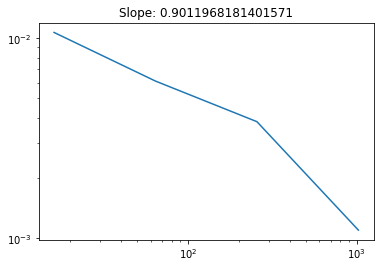

Error vector: [0.01069001 0.00610389 0.00382345 0.00109618]


/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


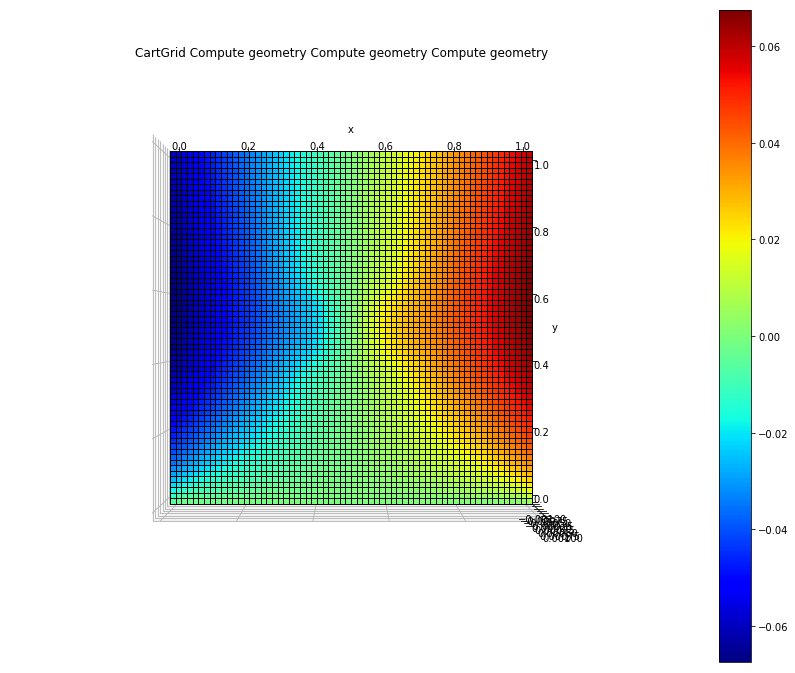

In [36]:
test_grid_convergence(ud='ux')

## Plot grid convergence in y-direction 

/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/home/haakon/anaconda3

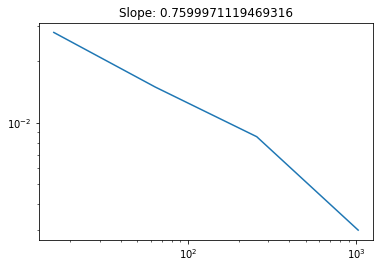

Error vector: [0.02774676 0.01499115 0.0085649  0.00298647]


/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


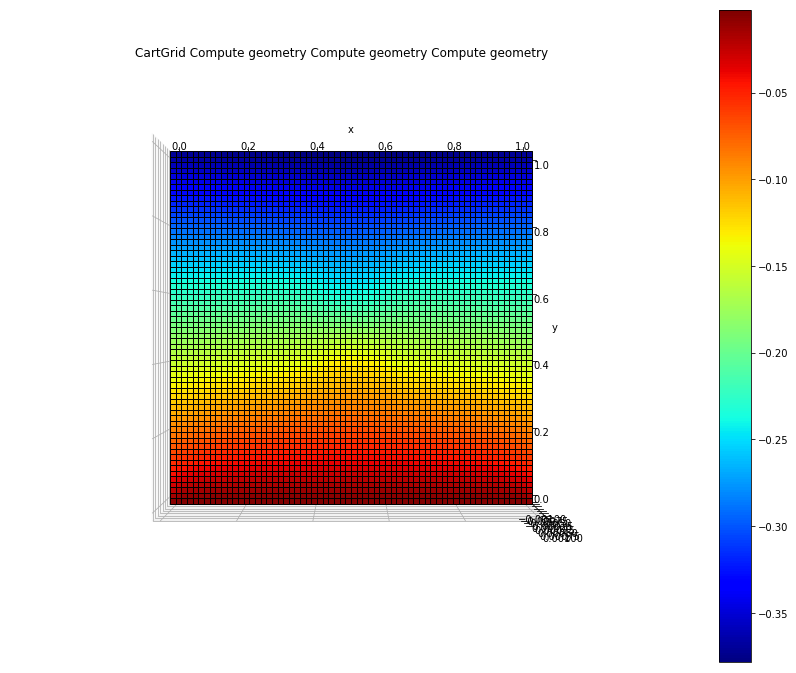

In [38]:
test_grid_convergence(ud='uy')